## TODO

- [ ] Make sure we have 59 patients with RBD
- [ ] Including 17 with MCI
- [ ] 41 Healthy controls

# Replication: Rahayel *et al*, 2018
## Introduction

This notebook attempts to replicate the following paper with the [PPMI](http://ppmi-info.org) dataset:

<div class="alert alert-block alert-success">
Shady Rahayel, et al. <a href=https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5957304/>Cortical and subcortical gray matter bases of cognitive deficits in REM sleep behavior disorder</a> Neurology, vol. 90, no. 20, pp. e1759–e1770, 2018.
</div>

This study involved 59 patients with polysomnography confirmed RBD, including 17 with MCI. They were compared to 41 controls.

In [1]:
# Write more on what are the findings of the paper

The remainder of this notebook is an attempt to replicate this result using the PPMI dataset.

## Initial setup

<!-- LivingPark notebooks use a *cache* directory to store analysis inputs and outputs. Inputs typically include PPMI Study Data and imaging data whereas outputs include processed images and other derivatives. Cache directories allow LivingPark notebooks to run in a few minutes as they reuse previously computed results. However, cache directories cannot be made public due to the PPMI Data Usage Agreement (DUA). Instead, they are stored on `login.bic.mni.mcgill.ca`, which requires a specific user name and password. In case you don't have access to the cache directory of this notebook, the next sections will download all the required imaging data from PPMI and recompute the results, which will take a few hours depending on your computer configuration. In the future, we will aim at storing this cache dataset on PPMI servers so that they can be accessed with a PPMI account. -->

Let's initialize the notebook directory and software dependencies:

In [2]:
import livingpark_utils

utils = livingpark_utils.LivingParkUtils()
random_seed = 2
utils.notebook_init()
# random_seed = 1 # to be tested
#random_seed = 2  # no significant cluster
# random_seed = 3 # no significant cluster
# random_seed = 4 # no significant cluster

removing link inputs
removing link outputs
This notebook was run on 2023-02-07 03:22:16 UTC +0000


## PPMI cohort preparation

We will build a PPMI cohort that matches the one used in the original study (Table 1) as much as possible. As in other LivingPark replications, we will use the same sample size as the original study. Our cohort will be built directly from PPMI Study Data files so that it can be replicated and updated whenever necessary.

### Study data download

We will start by downloading the PPMI Study Data files required to build our cohort: 
* Demographics (to retrieve sex)
* REM Sleep Behavior Disorder Questionnaire (for RBD score)
* Prodromal History (for polysomnographies)
* Primary Clinical Diagnosis (to include only healthy subjects)
* Cognitive Categorization (to exclude subjects with dementia)
* Medical Condition (to exclude neurological and psychiatric disorders)
* Concomitant Medication Log (to exclude medication known to modify REM sleep architecture and muscle tone)

We will use the LivingPark utils library to download these files from the notebook. If files are already present in the notebook cache, they won't be downloaded again. Otherwise, you will need to enter your PPMI username and password. In case you don't have a PPMI account, you can request one [here](http://ppmi-info.org).

In [3]:
required_files = [
    "Demographics.csv",
    "REM_Sleep_Behavior_Disorder_Questionnaire.csv",
    "Primary_Clinical_Diagnosis.csv",
    "Cognitive_Categorization.csv",
    "Medical_Conditions_Log.csv",
    "Concomitant_Medication_Log.csv",
    "Prodromal_History.csv",
]

utils.download_ppmi_metadata(required_files, headless=False)

Download skipped: No missing files!


/tmp/ipykernel_334721/2927919574.py:11: DeprecationWarning: Call to deprecated function download_ppmi_metadata.
This function will be remove in future version.
Moved to function `livinpark_utils::LivingParkUtils::get_study_files`.
  utils.download_ppmi_metadata(required_files, headless=False)


We will also need file `MRI_info.csv` produced by another LivingPark notebook available at https://github.com/LivingPark-MRI/livingpark-utils/blob/main/livingpark_utils/notebooks/mri_metadata.ipynb. This file contains a list of T1-weighted MRIs usable for VBM. 

In [4]:
# %%capture
# from livingpark_utils.scripts import (
#     mri_metadata,
#     pd_status,
# )

### RBD Score computation

The original study used polysomnography to diagnose REM Sleep Behavior Disorder. While polysomnography is available in the PPMI prodromal cohort, as of July 2022 the number of subjects matching the inclusion/exclusion criteria in this cohort is not enough to replicate the original study (see also Section "Inclusion criteria").
Instead, we will use the REM Sleep Behavior Disorder Screening Questionnaire (RSBDSQ) [[1]](https://movementdisorders.onlinelibrary.wiley.com/doi/10.1002/mds.21740) to discriminate RBD patients from controls. This questionnaire consists of 13 yes/no questions that are summed to produce an RBD score. We computed the RBD score by summing the answers to each of the 13 questions. The answers to questions Q1 to Q9 (12 questions as Q6 is sub-divided in 4 parts) are directly availble in the RSBDSQ Study Data file. We computed the answer to Q10 ("I have/had a disease of the nervous system (e.g., stroke, head trauma, parkinsonism, RLS, narcolepsy, depression, epilepsy, inflammatory disease of the brain), which?") by taking the max of the 8 corresponding disease variables in the RSBDSQ Study Data file. We also computed the answer to Q6 as the sum of Q6.1 to Q6.4 as it will use as inclusion criterion for controls.

We obtain the following distribution of RBD scores in the PPMI dataset:

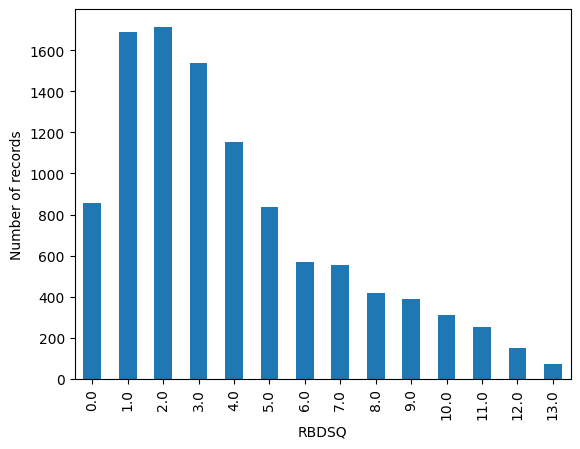

In [22]:
import os
import pandas as pd

# Load PPMI RSBDQ data
rbdsq = pd.read_csv(
    os.path.join(utils.study_files_dir, "REM_Sleep_Behavior_Disorder_Questionnaire.csv")
)

# Compute RBDSQ score
rbdsq["RBDSQ"] = (
    rbdsq["DRMVIVID"]  # Q1
    + rbdsq["DRMAGRAC"]  # Q2
    + rbdsq["DRMNOCTB"]  # Q3
    + rbdsq["SLPLMBMV"]  # Q4
    + rbdsq["SLPINJUR"]  # Q5
    + rbdsq["DRMVERBL"]  # Q6.1
    + rbdsq["DRMFIGHT"]  # Q6.2
    + rbdsq["DRMUMV"]  # Q6.3
    + rbdsq["DRMOBJFL"]  # Q6.4
    + rbdsq["MVAWAKEN"]  # Q7
    + rbdsq["DRMREMEM"]  # Q8
    + rbdsq["SLPDSTRB"]  # Q9
    + rbdsq[  # Q10
        [
            "BRNINFM",
            "DEPRS",
            "EPILEPSY",
            "HETRA",
            "NARCLPSY",
            "PARKISM",
            "RLS",
            "STROKE",
        ]
    ].max(axis=1)
)

rbdsq["Q6"] = (
    rbdsq["DRMVERBL"] + rbdsq["DRMFIGHT"] + rbdsq["DRMUMV"] + rbdsq["DRMOBJFL"]
)

# Note: CNSOTHCM isn't present in data

# Check that max RBDSQ score is <= 13
assert rbdsq["RBDSQ"].max() <= 13

rbdsq = rbdsq[["PATNO", "EVENT_ID", "Q6", "RBDSQ", "STROKE", "EPILEPSY"]]

rbdsq.groupby("RBDSQ").count()["PATNO"].plot.bar()

from matplotlib import pyplot as plt

plt.ylabel("Number of records")
plt.show()

### Inclusion criteria

To replicate the cohort in the original study, we used the following inclusion and exclusion criteria among PPMI subjects.

1. No Parkinsonim: we included PPMI subjects with PRIMDIAG = 17 (no PD nor other neurological disorder) or PRIMDIAG = 25 (prodromal). **TODO**: check with Madeleine if prodromal is ok. Otherwise, it reduces even more the number of subjects with polysomnographies (which are currently too few anyway so not an issue).

2. T1-weighted MRI available and usable for VBM (see [MRI metadata notebook](https://github.com/LivingPark-MRI/livingpark-utils/blob/main/livingpark_utils/notebooks/mri_metadata.ipynb)).

3. No dementia: we excluded subjects with COGSTATE = 3.

4. No neurological or psychiatric illness and no evidence of central nervous system (CNS) comorbidities: we excluded subjects with MHCAT in ["1P"] or [114] (neurologic and psychiatric disease). **TODO** check with Madeleine if these codes also account for CNS comorbitities.

Participants with a history of 
- stroke, x - REMSLEEP
- head trauma, x
- brain injury, x
- unstable hypertension or diabetes - Concomittent - CMINDC - 14 (hypertension) - 11 (diabetes)
- chronic obstructive pulmonary disease - MHCAT 105 - 1G
- claustrophobia (nowhere)
- EEG abnormalities suggesting epilepsy x - REMSLEEP
- encephalitis
- or any other neurologic disorders,- MHCAT 114 - 1P + PRIMDIAG 17 or 97
- or with artifacts on brain scans were excluded.

5. RBD group: we included subjects when their RBD score is >= 5.

6. Control group: we included subjects when their RBD score is < 5 and their score to Q6 of the RSBDSQ is 0. **TODO** ref needed, see email thread between Madeleine and Ron Postuma

In case multiple visits of a given subject are included in the RBD or Control group, we randomly select one of them for inclusion in the group and exclude the other ones. This selection ensures that a given subject is included at most once in the RBD group and at most once in the control group. In Section "Cohort matching", we will ensure that a given subjet is included in at most one group. 

We obtain the following group sizes:

<!-- and a cutoff score of 6 to identify RBD subjects among PD subjects, consistently with the results presented in [[2]](https://www.sciencedirect.com# /science/article/pii/S138994571100164X). -->

In [65]:
# Read data files

# Prodromal history
prodr_hist = pd.read_csv(os.path.join(utils.study_files_dir, 'Prodromal_History.csv'))[["PATNO", "RBDDIAG", "RBDPSG"]]

# MRI info
mri = pd.read_csv(os.path.join(utils.study_files_dir, "MRI_info.csv"))[
    ["Subject ID", "Visit code", "Description", "Age"]
]
mri.rename(columns={"Subject ID": "PATNO", "Visit code": "EVENT_ID"}, inplace=True)

# Demographics
dem = pd.read_csv(os.path.join(utils.study_files_dir, "Demographics.csv"))[["PATNO", "SEX"]]

# Diagnosis
diag = pd.read_csv(os.path.join(utils.study_files_dir, "Primary_Clinical_Diagnosis.csv"))[
    ["PATNO", "EVENT_ID", "PRIMDIAG", "OTHNEURO"]
]

# Cognitive Categorization
cog_cat = pd.read_csv(os.path.join(utils.study_files_dir, "Cognitive_Categorization.csv"))[
    ["PATNO", "EVENT_ID", "COGSTATE"]
]

# Medical condition
med_cond = pd.read_csv(os.path.join(utils.study_files_dir, "Medical_Conditions_Log.csv"))[
    ["PATNO", "EVENT_ID", "MHCAT"]
].groupby(['PATNO', 'EVENT_ID'])[['MHCAT']].aggregate(lambda x: tuple(set(x))) # aggregate all codes in a tuple

# Medication
meds = pd.read_csv(os.path.join(utils.study_files_dir, "Concomitant_Medication_Log.csv"))[
    ["PATNO", "EVENT_ID", "SEQNO", "CMTRT", "CMINDC"]
].groupby(['PATNO', 'EVENT_ID'])[['CMTRT', 'CMINDC']].aggregate(lambda x: tuple(x)) # aggregate all meds in a tuple

def included(subjects, with_mci=False):
    '''
    Return subjects complying to the inclusion criteria mentioned before.
    
    Parameters
    ----------
    subjects: DataFrame. Has to contain columns PATNO and EVENT_ID and PRIMDIAG
    '''
    temp =  (subjects.merge(dem, on="PATNO", how="inner") # Sex is available
     .merge(diag[diag['PRIMDIAG'].isin([17, 25])], on=["PATNO", "EVENT_ID"], how="inner") # Subject is healthy or prodromal
     .merge(mri, on=["PATNO", "EVENT_ID"], how="inner")  # MRI usable for VBM is available
     .merge(cog_cat[cog_cat["COGSTATE"] == 2 if with_mci else cog_cat["COGSTATE"] == 1], how="inner", on=["PATNO", "EVENT_ID"])  # No dementia
     .merge(med_cond, on=["PATNO", "EVENT_ID"], how="left")
     .merge(meds, on=["PATNO", "EVENT_ID"], how="left")
     
             [
        [
            "PATNO",
            "EVENT_ID",
            "RBDSQ",
            "Q6",
            "SEX",
            "Age",
            "Description",
            "PRIMDIAG",
            "COGSTATE",
            "MHCAT",
            "CMTRT",
            "CMINDC"
        ]
    ]
            )
    
    # Check medical condition and return
    def check_mhcat(x):
        import numpy as np
        if type(x) == tuple:
            return not ("1P" in x or "1G" in x)
        else:
            return np.isnan(x)
        
    # Check concomitant medication log indication and return
    def check_indication(x):
        import numpy as np
        if type(x) == tuple:
            return not (14 in x or 11 in x)
        else:
            return np.isnan(x)
        
#     print(temp)
        
    return temp[(temp["MHCAT"].apply(check_mhcat)) & (temp["CMINDC"].apply(check_indication))]  # No neurological or psychiatric illness and no evidence of central nervous system (CNS) comorbidities

# Extract RBD subjects and controls according to inclusion criteria
# Sample one entry (event and T1 description) per subject in each group so that a subject happens at most once in a group (between-group consistency will be ensured in cohort matching)
# Sort entries by PATNO to improve reproducibility of this notebook

rbds_poly =  included((prodr_hist[(prodr_hist['RBDDIAG']==1) & (prodr_hist['RBDPSG']==1)].merge(rbdsq, on="PATNO", how="inner")))
if len(rbds_poly) !=0 : 
    rbds_poly = (rbds_poly.groupby("PATNO")
    .sample(1, random_state=random_seed)
    .sort_values(by="PATNO"))
    
rbds_poly_mci =  included((prodr_hist[(prodr_hist['RBDDIAG']==1) & (prodr_hist['RBDPSG']==1)].merge(rbdsq, on="PATNO", how="inner")), True)
if len(rbds_poly_mci) !=0 : 
    rbds_poly_mci = (rbds_poly.groupby("PATNO")
    .sample(1, random_state=random_seed)
    .sort_values(by="PATNO"))
    
rbds_poly_wo_mci =  included((prodr_hist[(prodr_hist['RBDDIAG']==1) & (prodr_hist['RBDPSG']==1)].merge(rbdsq, on="PATNO", how="inner")))
if len(rbds_poly_wo_mci) !=0 : 
    rbds_poly_wo_mci = (rbds_poly.groupby("PATNO")
    .sample(1, random_state=random_seed)
    .sort_values(by="PATNO"))

rbds_sq = (included(rbdsq[(rbdsq["RBDSQ"] >= 5) & (rbdsq["STROKE"] == 0) & (rbdsq["EPILEPSY"] == 0)]).groupby("PATNO")
    .sample(1, random_state=random_seed)
    .sort_values(by="PATNO"))
rbds_sq_mci = (included(rbdsq[(rbdsq["RBDSQ"] >= 5) & (rbdsq["STROKE"] == 0) & (rbdsq["EPILEPSY"] == 0)], True).groupby("PATNO")
    .sample(1, random_state=random_seed)
    .sort_values(by="PATNO"))
rbds_sq_wo_mci = (included(rbdsq[(rbdsq["RBDSQ"] >= 5) & (rbdsq["STROKE"] == 0) & (rbdsq["EPILEPSY"] == 0)]).groupby("PATNO")
    .sample(1, random_state=random_seed)
    .sort_values(by="PATNO"))
controls = (included(rbdsq[(rbdsq["RBDSQ"] < 5) & (rbdsq["Q6"] == 0) & (rbdsq["STROKE"] == 0) & (rbdsq["EPILEPSY"] == 0)]).groupby("PATNO")
    .sample(1, random_state=random_seed)
    .sort_values(by="PATNO"))

# print(f"Number of RBD subjects w/ polysomnography: {len(rbds_poly)}")
# print(f"Number of RBD subjects w/o polysomnography: {len(rbds_sq['PATNO'])}")
print(f"Number of RBD subjects w/ polysomnography w/o MCI: {len(rbds_poly_wo_mci)}")
print(f"Number of RBD subjects w/ polysomnography w/ MCI: {len(rbds_poly_mci)}")
print(f"Number of RBD subjects w/o polysomnography w/o MCI: {len(rbds_sq_wo_mci['PATNO'])}")
print(f"Number of RBD subjects w/o polysomnography w/ MCI: {len(rbds_sq_mci['PATNO'])}")
print(f"Number of control subjects: {len(controls['PATNO'])}")


if len(rbds_poly) < 52:
    print("We don't have enough RBD subjects with polysomnography. Let's use RBD subjects without polysomnography in this replication.")
    rbds = rbds_sq
else:
    print("We have enough RBD subjects with polysomnography to use them in this replication.")
    rbds = rbds_poly

Number of RBD subjects w/ polysomnography w/o MCI: 8
Number of RBD subjects w/ polysomnography w/ MCI: 0
Number of RBD subjects w/o polysomnography w/o MCI: 41
Number of RBD subjects w/o polysomnography w/ MCI: 2
Number of control subjects: 95
We don't have enough RBD subjects with polysomnography. Let's use RBD subjects without polysomnography in this replication.


### Cohort matching

The RBD and Control groups built previously give us a lot of flexibility to build a cohort that matches the one in the original study, due to their large sample size compared to the original cohort. We adopted the following approach to construct a matching cohort:
1. Randomly select 4 control women and 10 control men, to reproduce the F/M balance in the original study
2. Find 26 subjects from the RBD group that best match age and sex in the selected control group. We matched sex by direct sampling of males and females using the same proportion as in the original study. We matched age using a nearest-neighbor approach.

---

- controls 61% men - 25 | 65.5 (6.6) 
- RBD 81% men - 42 | 67.9 (4.4) 
- RBD w MCI 71% men - 12 | 64.4 (7.2)
- RBC wo MCI 86% men - 30 | 63.2 (8.2)

---

We obtain the following cohort:

In [44]:
def nn_match(sample1, df_2, n2, cat_variables, num_variables, random_state=random_seed):
    """
    Find len(sample1) rows in df_2 such that variables are matched with sample1.

    sample1: samples in group1
    df_2: dataframe with subjects in group 2
    n2: desired sample size for group 2
    cat_variables: categorical variables to match
    num_variables: numerical variables to match
    """

    def nn(x, df, variables):
        """
        Find index of nearest neighbor of x in df

        * x: a dataframe row
        * df: a dataframe
        * variables: variables to match. Should be normalized.
        """
        df["dist"] = sum((df[var] - x[var]) ** 2 for var in variables)
        df.sort_values("dist", inplace=True)
        return df.head(1).index[
            0
        ]  ## there's probably a better way to do it but it works

    # Check assumptions
    n1 = len(sample1)
    assert n1 <= n2
    for v in num_variables + cat_variables:
        assert v in sample1 and v in df_2

    # Copy original dataframe to leave it untouched
    df_2_ = df_2.copy()
    sample1_ = sample1.copy()

    # Remove from df_2 all subjects that are in sample1
    df_2_ = df_2_[~df_2_["PATNO"].isin(sample1["PATNO"])]

    # Normalize variables to match to compute meaningful distances
    for v in num_variables:
        m = df_2_[v].mean()
        s = df_2_[v].std()
        for df in (df_2_, sample1_):
            df[v] = (df[v] - m) / s

    # For each subject in sampled group 1,
    # find one or more subject in sampled group 2, without replacement.
    indices = []
    for i in range(n2):
        j = i % n1  # loop over sample1
        df_2_cat = df_2_.copy()
        for c in cat_variables:
            if len(df_2_cat[df_2_cat[c] == sample1_.iloc[j][c]]) > 0:
                df_2_cat = df_2_cat[df_2_cat[c] == sample1_.iloc[j][c]]
            else:
                print(
                    f"Warning: cannot find subject with {c}=={sample1_.iloc[j][c]} in sample 2. Removing constraint."
                )
        index = nn(sample1_.iloc[j], df_2_cat, num_variables)
        df_2_.drop(index=index, inplace=True)
        indices.append(index)

    sample2 = df_2[df_2.index.isin(indices)]

    return sample2

In [42]:
# Randomly select 4 control women and 10 control men, to reproduce F/M balance in original paper
controls = pd.concat(
    [
        controls[controls["SEX"] == 0].sample(
            n=5, random_state=random_seed
        ),  # 4/10 doesn't work for RBDs
        controls[controls["SEX"] == 1].sample(n=9, random_state=random_seed),
    ]
)

# Match with RBD subjects
rbds = nn_match(controls, rbds, 27, ["SEX"], ["Age"], random_state=random_seed)

In [40]:
import os

cohort_stats = pd.DataFrame(columns=["iRBD Patients", "Controls"])

cohort_stats.loc["Subjects, No."] = [len(rbds), len(controls)]
cohort_stats.loc["F/M, No."] = [
    f"{len(rbds[rbds['SEX']==0])}/{len(rbds[rbds['SEX']==1])}",
    f"{len(controls[controls['SEX']==0])}/{len(controls[controls['SEX']==1])}",
]
cohort_stats.loc["Age, mean +/- SD"] = [
    f"{round(rbds['Age'].mean(),1)} +/- {round(rbds['Age'].std(),1)}",
    f"{round(controls['Age'].mean(),1)} +/- {round(controls['Age'].std(),1)}",
]

cohort_stats

,iRBD Patients,Controls
"Subjects, No.",27,14
"F/M, No.",10/17,5/9
"Age, mean +/- SD",63.7 +/- 7.5,64.2 +/- 9.5


The demographics parameters of the selected PPMI subjects seem comparable to the ones in the initial study. 

Let's do basic sanity checks in this cohort:
* A subject appears at most once in each group
* A subject does not appear in more than one group

In [ ]:
assert len(pd.unique(rbds["PATNO"])) == len(
    rbds
), "Some subjects are present more than once in RBD group"
assert len(pd.unique(controls["PATNO"])) == len(
    controls
), "Some subjects are present more than once in controls"
assert (
    len(set(controls["PATNO"]) & set(rbds["PATNO"])) == 0
), f'Some subjects are present in controls and rbd group {set(controls["PATNO"]) & set(rbds["PATNO"])}'
print("All sanity checks passed.")

In [ ]:
# Concatenate both groups in cohort DataFrame
rbds["group"] = "RBD"
controls["group"] = "Control"
cohort = pd.concat([rbds, controls])

In [ ]:
cohort

Finally, we generate a cohort id that uniquely identifies the cohort built previously. We will use this id to avoid recomputing the same results multiple times:

In [ ]:
cohort_id = utils.cohort_id(cohort)
print(f"Cohort id: {cohort_id}")

In [ ]:
# Save patient ids
filename = f"scherfler-etal-patnos-{cohort_id}.csv"
cohort["PATNO"].to_csv(filename, index=False)
print(f"Cohort patient ids saved in {filename}. Do not share this file publicly!")

The following concommittant medication have been found in the cohort. Make sure that they don't violate the following exclusion criteria from the original paper:

No current treatment with medications known to modify REM sleep architecture and muscle tone such as serotonin reuptake inhibitors.

In [ ]:
cohort.groupby("CMTRT").count()[["PATNO"]]

## Paper replication

Having our cohort is ready, we will now proceed to reproduce the MRI-based results of the paper.

## Image Processing

The authors conducted cortical reconstruction and volumetric segmentation on the MRI data using the Freesurfer 5.3 image analysis software, following standard procedures.

The initial processing of T1 MRI images for each subject at each time point (baseline and follow-up) involves the following steps: 
* removal of non-brain tissue
* Talairach transformation
* segmentation of subcortical white matter and deep grey matter volumetric structures
* intensity normalization
* cortical reconstruction

Since there is already PPMI image processed with Freesurfer 6.0.1 on the BIC server, we will start the volumetric analysis of subcortical structures from there.

```This processing includes removal of
nonbrain tissue, Talairach transformation, segmentation of
the subcortical white matter and deep gray matter volumetric structures, intensity normalization, and cortical
reconstruction.19,20 Cortical thickness and volume maps
were smoothed using a 15-mm full-width at half-maximum
gaussian smoothing kernel and cortical surface area maps
with a 20-mm smoothing kernel. Different smoothing filter
sizes were used to increase the sensitivity for each structural
metric, because a filter that is optimal for one metric may not
be applicable to another.2```